# 1. Import Libraries 

In [1]:
import os
import glob
import sys
import time

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', None)
import seaborn as sns
import altair as alt

from skimage import img_as_ubyte, io, color
import cv2

from sklearn.model_selection import train_test_split

#Data balancing SMOTE - imblearn
from imblearn.over_sampling import SMOTE

#PyTorch
import torch
import torch.nn as nn
import torch.nn.functional as F

#Skorch
from skorch import NeuralNetClassifier
from skorch.callbacks import EarlyStopping, LRScheduler, EpochScoring,ProgressBar, Checkpoint
from skorch.dataset import CVSplit, ValidSplit
from skorch.callbacks import TrainEndCheckpoint

#model performance
from sklearn.metrics import classification_report,confusion_matrix,ConfusionMatrixDisplay,top_k_accuracy_score

#Scaling
from sklearn.preprocessing import StandardScaler, MinMaxScaler

#Distnce Matrix
from scipy.spatial import distance_matrix

#Supress warnings
import warnings
from sklearn.exceptions import DataConversionWarning
warnings.filterwarnings(action='ignore')


# 2. Import Data

### 2.1 Load Train data 

In [3]:
TrainData01 = pd.read_csv("C:/Dissertation/Data/Processed Data/TrainData01.csv")

TrainData02 = pd.read_csv("C:/Dissertation/Data/Processed Data/TrainData02.csv")

TrainData03 = pd.read_csv("C:/Dissertation/Data/Processed Data/TrainData03.csv")

### 4.2 Define X and y 

In [14]:
# Pre defined Test split 01
X1 = TrainData01.iloc[:,2:2050]
y1 = TrainData01.iloc[:,2052:2137]

# Pre defined Test split 02
X2 = TrainData02.iloc[:,2:2050]
y2 = TrainData02.iloc[:,2052:2137]

# Pre defined Test split 03
X3 = TrainData03.iloc[:,2:2050]
y3 = TrainData03.iloc[:,2052:2137]

### 4.3 Spilt in to train and validation for projection network

In [25]:
X_train1,X_val_seen_classes1,y_train1,y_val_seen_classes1 = train_test_split(X1,y1,stratify=y1,test_size=0.1,random_state = 0)

X_train2,X_val_seen_classes2,y_train2,y_val_seen_classes2 = train_test_split(X2,y2,stratify=y2,test_size=0.1,random_state = 0)

X_train3,X_val_seen_classes3,y_train3,y_val_seen_classes3 = train_test_split(X3,y3,stratify=y3,test_size=0.1,random_state = 0)

# 5. Setup Neural Network Architecture

### 5.1 Define DNN for projection network

In [3]:
class ProjectionNetwork(nn.Module):
    def __init__(self, num_units, non_linear,dropout):
        super(ProjectionNetwork, self).__init__()        
        self.fc1 = nn.Linear(2048, num_units)  
        self.fc2 = nn.Linear(num_units, num_units) 
        self.fc3 = nn.Linear(num_units, 85) 
        self.nonlinear = non_linear  
        self.dropout = nn.Dropout(dropout)
                        
    def forward(self, x):
        out = self.fc1(x)
        out = self.nonlinear(out)
        out = self.dropout(out)
        out = self.fc2(out)
        out = self.nonlinear(out)
        out = self.dropout(out)
        out = self.fc3(out)
        return out    


### 5.2 Define evaluation criterea and checkpoint for projection network

In [4]:
# Create Skorch EPOCHScoring   
train_macro_F1_score = EpochScoring(scoring='f1_macro', lower_is_better=False, name = 'train_f1_macro', on_train = True)
valid_macro_F1_score = EpochScoring(scoring='f1_macro', lower_is_better=False, name = 'valid_f1_macro', on_train = False)

# Create Checkpoint
CP1 = Checkpoint(monitor='valid_loss_best',dirname='exp1')
CP2 = Checkpoint(monitor='valid_loss_best',dirname='exp2')
CP3= Checkpoint(monitor='valid_loss_best',dirname='exp3')
CP_final= Checkpoint(monitor='valid_loss_best',dirname='exp_final')

### 5.3 Check for GPU

In [5]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)
torch.cuda.empty_cache()
if device.type == 'cuda':
    print(torch.cuda.get_device_name(0))
    print('Memory Usage:')
    print('Allocated:', round(torch.cuda.memory_allocated(0)/1024**3,1), 'GB')
    print('Cached:   ', round(torch.cuda.memory_reserved(0)/1024**3,1), 'GB')

Using device: cuda
NVIDIA GeForce RTX 3060 Laptop GPU
Memory Usage:
Allocated: 0.0 GB
Cached:    0.0 GB


# 6A. Train Model - Predefined Train data 01

### 6A.0 Define SKORCH model parameters for Train Model 01

In [6]:
torch.manual_seed(0)

net_train01 = NeuralNetClassifier(
ProjectionNetwork,
#iterator_train__shuffle=True, 
#iterator_valid__shuffle=True, 
batch_size=64,
module__num_units = 5096, #5096
module__non_linear = nn.ReLU(),
module__dropout = 0.2,
max_epochs=50,
lr=0.1,
criterion = torch.nn.modules.loss.BCEWithLogitsLoss, # to use with Sigmoid 
optimizer=torch.optim.SGD,
#optimizer__momentum = 0.95,
#optimizer__weight_decay = 0.001,
train_split = ValidSplit(5),
callbacks=[train_macro_F1_score,valid_macro_F1_score, CP1],
callbacks__valid_acc=None,
device='cuda'
)

In [30]:

X01= X_train1.astype(np.float32).values
y01 = y_train1.astype(np.float32).values
net_train01.fit(X01,y01)#to use with sigmoid and BCELOSS
#y1 = y_train_composite.astype(np.int64).values

  epoch    train_f1_macro    train_loss    valid_f1_macro    valid_loss    cp     dur
-------  ----------------  ------------  ----------------  ------------  ----  ------
      1            0.5475        0.3494            0.7455        0.2063     +  9.4471
      2            0.8383        0.1595            0.8962        0.1233     +  4.1202
      3            0.9080        0.1069            0.9244        0.0899     +  3.9014
      4            0.9274        0.0827            0.9356        0.0730     +  3.7682
      5            0.9369        0.0688            0.9420        0.0626     +  3.8923
      6            0.9428        0.0595            0.9464        0.0554     +  3.9999
      7            0.9468        0.0531            0.9492        0.0502     +  3.8427
      8            0.9498        0.0480            0.9512        0.0466     +  3.9146
      9            0.9521        0.0440            0.9529        0.0431     +  3.9107
     10            0.9541        0.0407            0.9

<class 'skorch.classifier.NeuralNetClassifier'>[initialized](
  module_=ProjectionNetwork(
    (fc1): Linear(in_features=2048, out_features=5096, bias=True)
    (fc2): Linear(in_features=5096, out_features=5096, bias=True)
    (fc3): Linear(in_features=5096, out_features=85, bias=True)
    (nonlinear): ReLU()
    (dropout): Dropout(p=0.2, inplace=False)
  ),
)

In [31]:
net_train01.load_params(checkpoint=CP1)

### 6A.1 Plot Training and Validation Error

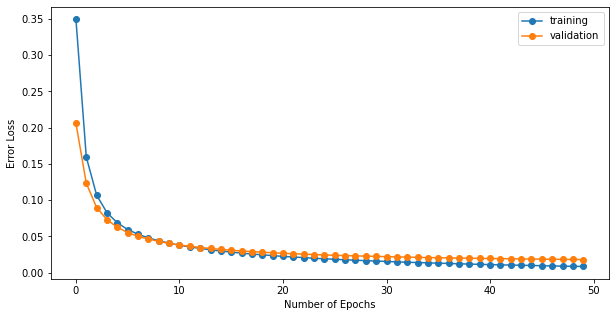

In [32]:
train_loss = net_train01.history[:, 'train_loss']
valid_loss = net_train01.history[:, 'valid_loss']
plt.figure(figsize=(10,5))
plt.plot(train_loss, 'o-', label='training')
plt.plot(valid_loss, 'o-', label='validation')
plt.xlabel('Number of Epochs', fontsize=10)
plt.ylabel('Error Loss', fontsize=10)
plt.legend()
plt.show() 

### 6A.2 Predict on X Val Seen Classes 01

In [33]:
y_pred01 = net_train01.predict(X_val_seen_classes1.astype(np.float32).values)

### 6A.3 print Classification Report

In [34]:
print(classification_report(y_val_seen_classes1.astype(np.float32).values, y_pred01, target_names=predicate_list))

              precision    recall  f1-score   support

       black       0.99      0.99      0.99      2141
       white       0.98      0.98      0.98      1607
        blue       0.99      0.98      0.99       268
       brown       0.99      0.99      0.99      2140
        gray       0.99      0.99      0.99      1872
      orange       1.00      0.98      0.99       267
         red       1.00      0.96      0.98       133
      yellow       1.00      0.99      1.00       134
     patches       0.98      0.96      0.97       803
       spots       0.98      0.96      0.97       402
     stripes       1.00      1.00      1.00       402
       furry       1.00      1.00      1.00      2810
    hairless       0.99      0.99      0.99       803
   toughskin       1.00      1.00      1.00      1607
         big       1.00      0.99      0.99      2275
       small       0.98      0.99      0.99      1472
     bulbous       0.99      0.99      0.99      1875
        lean       0.99    

### 6A.4 Plot Confusion Matrix

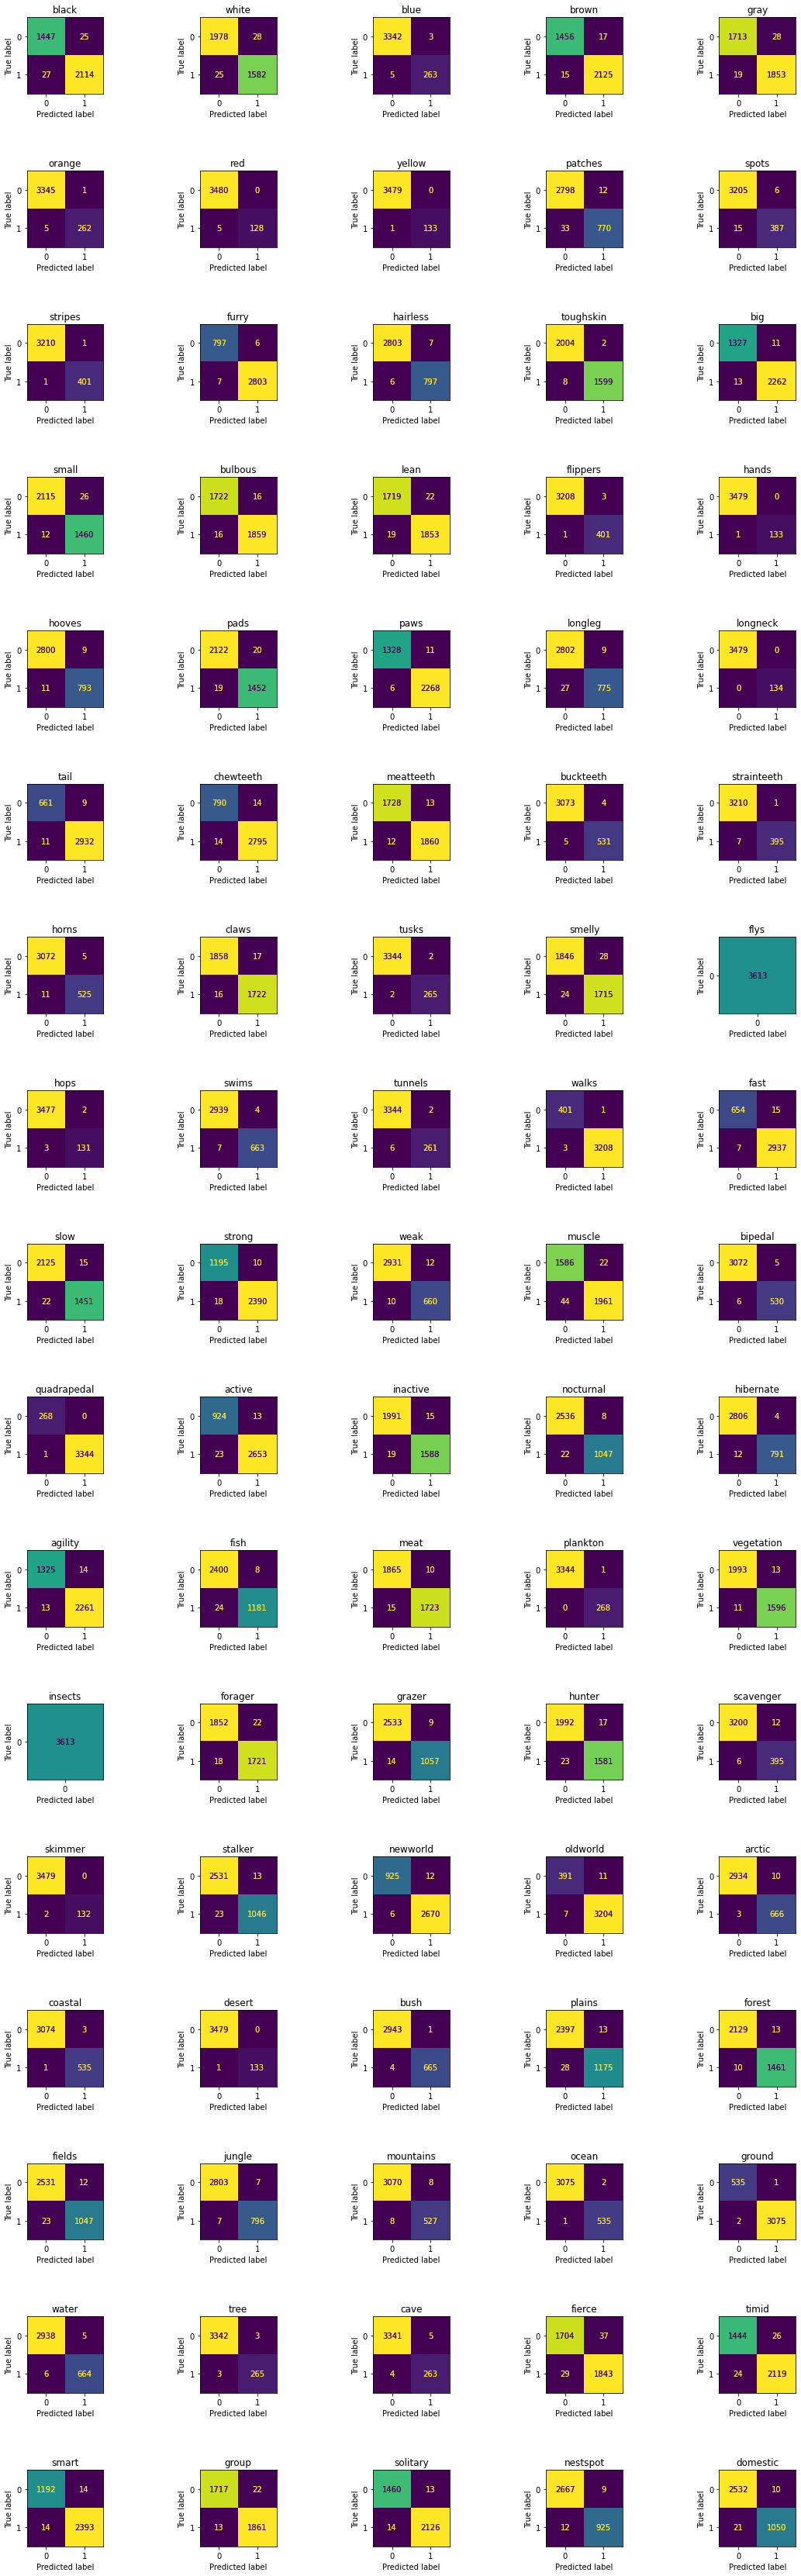

In [35]:
f, axes = plt.subplots(17, 5, figsize=(20, 60))
axes = axes.ravel()
for i in range(85):
    disp = ConfusionMatrixDisplay(confusion_matrix(y_val_seen_classes1.astype(np.float32).values[:, i], y_pred01[:, i]))
    disp.plot(ax=axes[i], values_format='.4g')
    disp.ax_.set_title(predicate_list[i])
    disp.im_.colorbar.remove()
    disp.plot(ax=axes[i])
    disp.im_.colorbar.remove()

plt.subplots_adjust(wspace=0, hspace=1)
plt.show()

# 6B. Zero Shot Prediction on Unseen ValidationData 01

### 6B.1 Load predefine unseen Validation data 01

In [36]:
ValData01 = pd.read_csv("C:/Dissertation/Data/Processed Data/ValData01.csv")
ValData01.head()

Unnamed: 0         filenames         0         1         2         3  \
0           0  beaver_10001.jpg  0.308759  0.158165  0.167194  1.326803   
1           1  beaver_10002.jpg  1.143482  0.338100  1.104502  1.084069   
2           2  beaver_10003.jpg  0.145042  0.436944  0.872302  2.536272   
3           3  beaver_10004.jpg  0.356365  0.150982  1.459180  1.075066   
4           4  beaver_10005.jpg  0.010020  0.618178  0.965204  3.019485   

          4         5         6         7         8         9        10  \
0  0.436551  0.337247  0.116172  0.270127  0.010202  1.206540  0.000000   
1  0.301288  0.558570  1.871308  0.079989  0.018362  1.559719  0.155811   
2  0.000000  0.164315  0.961526  0.624416  0.041490  0.072217  0.000000   
3  0.056077  0.100903  1.206283  0.000000  0.103623  0.216766  0.000000   
4  0.192714  0.355421  0.852097  0.022290  0.658007  0.063659  0.000000   

         11        12        13        14        15        16        17  \
0  0.000000  0.134817  0.001983  0.000000  0.029347  1.076074  0.663878   
1  0.000000  0.421687  0.000000  0.090744  1.390309  0.143701  1.151154   
2  0.166976  0.314935  0.000000  0.000000  1.290848  0.393799  0.431637   
3  0.549264  0.009316  0.290698  0.000973  0.866080  0.138171  1.091803   
4  0.000000  0.030265  0.000000  0.000000  0.076555  0.478587  1.170569   

         18        19        20        21        22        23        24  \
0  0.000000  0.002482  0.000000  0.605899  0.536610  0.070799  0.000000   
1  0.026780  0.874349  0.155670  0.815509  0.170574  0.288239  0.088635   
2  0.000000  0.764164  0.218857  0.023320  0.073139  1.354690  0.000000   
3  0.024555  0.851681  0.031809  0.171373  0.000000  3.248078  0.081908   
4  0.000000  1.084632  0.065842  0.207989  0.000000  1.157468  0.229477   

         25        26        27        28        29        30        31  \
0  0.434433  0.511607  0.213673  0.021109  0.000000  0.005144  0.006855   
1  0.049146  0.098884  0.115055  0.025045  0.022151  0.007880  0.002725   
2  0.037900  0.377973  0.136093  0.034282  0.000000  0.001656  0.052252   
3  0.047621  1.339138  0.042373  0.007422  0.049665  0.233079  0.000000   
4  1.205902  1.981375  0.226216  0.052746  0.000000  0.042459  0.002404   

         32        33        34        35        36        37        38  \
0  0.169236  0.000000  0.000000  0.151565  0.620967  1.408581  0.488329   
1  0.026659  0.090316  0.000000  0.117294  0.302090  1.608880  0.530294   
2  0.000000  0.176908  0.268864  0.090173  0.009059  0.111297  0.131635   
3  0.008750  0.832609  0.000000  1.450220  0.003296  1.132562  0.796265   
4  0.000000  0.145617  0.056916  0.189705  0.376810  1.233792  0.359303   

         39        40        41        42        43        44        45  \
0  0.000000  0.287439  1.247138  0.348224  0.153897  0.347873  0.317293   
1  0.000000  1.418796  1.569596  1.287583  0.036221  0.247283  0.107615   
2  0.015675  0.000000  0.989151  0.295777  0.000000  0.007561  0.024480   
3  0.074314  0.005413  0.000000  0.934683  0.000000  1.120754  0.000000   
4  0.000000  0.104967  0.660747  0.000000  2.121537  0.511910  0.130257   

         46        47        48        49        50        51        52  \
0  0.158849  0.000000  0.305948  1.356086  0.409523  0.057312  1.178038   
1  0.049790  0.000000  3.320728  0.162057  0.255144  0.124986  0.259167   
2  0.082802  0.047381  2.200244  0.140186  0.062218  0.000000  0.351372   
3  0.134822  0.435624  0.777812  0.014295  0.040438  0.297835  1.094888   
4  0.007464  0.000000  0.166590  0.092370  0.120551  0.091707  0.039258   

         53        54        55        56        57        58        59  \
0  0.114558  1.626576  0.043981  0.048163  0.037005  0.522861  0.224547   
1  0.735076  1.013996  0.102431  0.179228  0.000000  0.000000  0.042469   
2  0.060685  0.413572  0.120033  0.519911  1.042117  0.000000  0.000000   
3  0.009788  0.103367  0.000000  0.000000  0.603214  0.014598  0.017580   
4  0.340146  0.09128

### 6B.2 Predict labels for unseen ZSL classes Validation 01

In [37]:
y_pred_ZS01 = net_train01.predict(ValData01.iloc[:,2:2050].astype(np.float32).values)
predicatedf_ZSL01 = predicatedf[predicatedf['classes'].isin((val01_df.classes.unique()).tolist())]
predicates = np.array(predicatedf_ZSL01.iloc[:,1:86])

### 6B.3 Calculate pairwise Eucledian distance between predicted vectors and unseen class attribute vectors

In [38]:
euc_matrix01 = distance_matrix(y_pred_ZS01, predicates, p=2)
euc_matrix01_df = pd.DataFrame(euc_matrix01, columns = np.array(predicatedf_ZSL01.classes).tolist())
#euc_matrix01_df = MinMaxScaler().fit_transform(euc_matrix01_df)
euc_matrix01_df = pd.DataFrame(euc_matrix01_df, columns = np.array(predicatedf_ZSL01.classes).tolist())

### 6B.4 Assign predicted label based on minimum Eucleadna distance

In [39]:
euc_matrix01_df['ZS_prediction'] = euc_matrix01_df.idxmin(axis=1)
euc_matrix01_df.head()

,beaver,dalmatian,mole,leopard,moose,gorilla,ox,chimpanzee,hamster,rabbit,giant+panda,deer,raccoon,ZS_prediction
0,0.293570,0.800452,0.575171,0.646684,0.899526,0.825707,0.904326,0.793381,0.642492,0.644144,0.759185,0.819442,0.569339,beaver
1,0.175330,0.718350,0.500876,0.526011,0.836040,0.706740,0.884449,0.666945,0.569593,0.617341,0.572458,0.719684,0.489847,beaver
2,0.538842,0.826832,0.689334,0.474743,0.651995,0.494277,0.802121,0.666945,0.711828,0.866568,0.411920,0.760488,0.489847,giant+panda
3,0.175330,0.600783,0.448353,0.421462,0.836040,0.656483,0.843874,0.557983,0.518719,0.562202,0.493574,0.633917,0.376631,beaver
4,0.215824,0.800452,0.575171,0.599593,0.899526,0.779179,0.943309,0.743966,0.642492,0.644144,0.686155,0.780426,0.569339,beaver


In [40]:
ZS_matrix01 = pd.concat([euc_matrix01_df,ValData01['classes']], axis = 1)
ZS_matrix01.head()
#ZS_matrix01.to_csv("C:/Dissertation/Data/Processed Data/ZSL_Test01.csv")

,beaver,dalmatian,mole,leopard,moose,gorilla,ox,chimpanzee,hamster,rabbit,giant+panda,deer,raccoon,ZS_prediction,classes
0,0.293570,0.800452,0.575171,0.646684,0.899526,0.825707,0.904326,0.793381,0.642492,0.644144,0.759185,0.819442,0.569339,beaver,beaver
1,0.175330,0.718350,0.500876,0.526011,0.836040,0.706740,0.884449,0.666945,0.569593,0.617341,0.572458,0.719684,0.489847,beaver,beaver
2,0.538842,0.826832,0.689334,0.474743,0.651995,0.494277,0.802121,0.666945,0.711828,0.866568,0.411920,0.760488,0.489847,giant+panda,beaver
3,0.175330,0.600783,0.448353,0.421462,0.836040,0.656483,0.843874,0.557983,0.518719,0.562202,0.493574,0.633917,0.376631,beaver,beaver
4,0.215824,0.800452,0.575171,0.599593,0.899526,0.779179,0.943309,0.743966,0.642492,0.644144,0.686155,0.780426,0.569339,beaver,beaver


### 6B.5 ZSL performance top-1 accuracy

In [41]:
print(classification_report(ZS_matrix01['classes'],ZS_matrix01['ZS_prediction']))

              precision    recall  f1-score   support

      beaver       0.47      0.77      0.58       193
  chimpanzee       0.46      0.69      0.55       728
   dalmatian       0.83      0.31      0.45       549
        deer       0.89      0.85      0.87      1344
 giant+panda       0.32      0.29      0.30       874
     gorilla       0.57      0.15      0.24       872
     hamster       0.60      0.80      0.69       779
     leopard       0.53      0.86      0.66       720
        mole       0.02      0.02      0.02       100
       moose       0.70      0.40      0.51       704
          ox       0.66      0.90      0.76       728
      rabbit       0.66      0.23      0.34      1088
     raccoon       0.30      0.68      0.41       512

    accuracy                           0.56      9191
   macro avg       0.54      0.54      0.49      9191
weighted avg       0.60      0.56      0.53      9191



# 7A. Train Model - Predefined Train data 02

### 7A.0 Set up SKORCH model parameters

In [42]:
torch.manual_seed(0)
from skorch import NeuralNetClassifier

net_train02 = NeuralNetClassifier(
ProjectionNetwork,
iterator_train__shuffle=True, 
#iterator_valid__shuffle=True, 
batch_size=32,
module__num_units = 5096, #5096
module__non_linear = nn.ReLU(),
module__dropout = 0.2,
max_epochs=50,
lr=0.1,
criterion = torch.nn.modules.loss.BCEWithLogitsLoss, # to use with Sigmoid 
optimizer=torch.optim.SGD,
#optimizer__momentum = 0.95,
#optimizer__weight_decay = 0.001,
train_split = ValidSplit(5),
callbacks=[train_macro_F1_score,valid_macro_F1_score, CP2],
callbacks__valid_acc=None,
device='cuda'
)

In [43]:
X02= X_train2.astype(np.float32).values
y02 = y_train2.astype(np.float32).values
net_train02.fit(X02,y02)#to use with sigmoid and BCELOSS

  epoch    train_f1_macro    train_loss    valid_f1_macro    valid_loss    cp     dur
-------  ----------------  ------------  ----------------  ------------  ----  ------
      1            0.7393        0.2554            0.9026        0.1223     +  6.8994
      2            0.9218        0.0979            0.9376        0.0738     +  6.5481
      3            0.9414        0.0677            0.9480        0.0558     +  6.6694
      4            0.9491        0.0538            0.9536        0.0465     +  6.6892
      5            0.9535        0.0452            0.9564        0.0406     +  6.6763
      6            0.9568        0.0390            0.9586        0.0364     +  7.0070
      7            0.9591        0.0345            0.9601        0.0331     +  6.9343
      8            0.9610        0.0309            0.9609        0.0308     +  6.9893
      9            0.9624        0.0279            0.9620        0.0289     +  6.8793
     10            0.9636        0.0255            0.9

<class 'skorch.classifier.NeuralNetClassifier'>[initialized](
  module_=ProjectionNetwork(
    (fc1): Linear(in_features=2048, out_features=5096, bias=True)
    (fc2): Linear(in_features=5096, out_features=5096, bias=True)
    (fc3): Linear(in_features=5096, out_features=85, bias=True)
    (nonlinear): ReLU()
    (dropout): Dropout(p=0.2, inplace=False)
  ),
)

In [44]:
net_train02.load_params(checkpoint=CP2)

### 7A.1 Plot Training and Validation Error

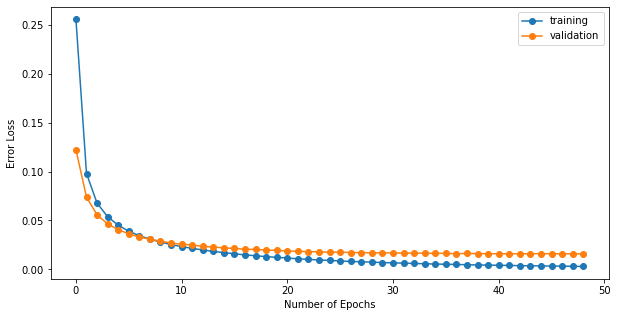

In [45]:
train_loss = net_train02.history[:, 'train_loss']
valid_loss = net_train02.history[:, 'valid_loss']
plt.figure(figsize=(10,5))
plt.plot(train_loss, 'o-', label='training')
plt.plot(valid_loss, 'o-', label='validation')
plt.xlabel('Number of Epochs', fontsize=10)
plt.ylabel('Error Loss', fontsize=10)
plt.legend()
plt.show() 

### 7A.2 Predict on X Val Seen Classes 02

In [46]:
y_pred02 = net_train02.predict(X_val_seen_classes2.astype(np.float32).values)

### 7A.3 print Classification Report

In [47]:
print(classification_report(y_val_seen_classes2.astype(np.float32).values, y_pred02, target_names=predicate_list))

              precision    recall  f1-score   support

       black       0.99      0.99      0.99      2283
       white       0.99      0.99      0.99      1478
        blue       1.00      1.00      1.00       135
       brown       1.00      1.00      1.00      2553
        gray       0.99      0.99      0.99      2016
      orange       1.00      1.00      1.00       134
         red       0.00      0.00      0.00         0
      yellow       1.00      1.00      1.00       268
     patches       0.99      0.99      0.99      1343
       spots       0.98      0.98      0.98       673
     stripes       0.99      0.99      0.99       269
       furry       1.00      1.00      1.00      3091
    hairless       1.00      0.99      1.00       538
   toughskin       0.99      0.99      0.99      1346
         big       1.00      1.00      1.00      2419
       small       0.99      0.99      0.99      1479
     bulbous       0.99      0.99      0.99      1881
        lean       0.99    

# 7B. Zero Shot Prediction on Unseen ValidationData 02

In [104]:
ValData02 = pd.read_csv("C:/Dissertation/Data/Processed Data/ValData02.csv")
ValData02.head()

Unnamed: 0           filenames         0         1         2         3  \
0           0  antelope_10001.jpg  0.127028  3.236108  0.935148  0.144205   
1           1  antelope_10002.jpg  0.000000  2.466911  0.026454  0.075211   
2           2  antelope_10003.jpg  0.383341  1.011904  0.000000  0.054472   
3           3  antelope_10004.jpg  0.117190  1.225786  0.001932  0.000000   
4           4  antelope_10005.jpg  0.274902  0.337544  0.084937  0.000000   

          4         5         6         7         8         9        10  \
0  1.114897  1.502288  0.410044  0.053410  0.000000  0.350173  0.054348   
1  1.159094  3.066645  0.191157  0.049365  0.017394  0.000000  0.331170   
2  0.343532  0.917366  0.044860  0.100728  0.266673  0.079659  0.081936   
3  3.135732  0.061605  0.974178  0.463193  0.057579  0.007712  0.171944   
4  1.788061  0.143165  0.250313  0.000000  0.134671  0.149908  0.036444   

         11        12        13        14        15        16        17  \
0  1.024090  0.020143  0.353289  0.011384  0.720656  0.217305  0.072973   
1  0.729361  0.000000  0.422115  0.102513  0.139059  0.056042  0.025745   
2  1.069659  0.144164  0.109519  0.002651  2.085719  0.000000  0.025379   
3  0.295372  0.017943  0.792748  0.088362  1.248844  0.086086  0.000000   
4  0.548512  0.000000  0.000000  0.018893  1.289334  0.011617  0.000000   

         18        19        20        21        22        23        24  \
0  0.445864  0.042429  0.106986  0.064491  0.220563  0.186625  0.064375   
1  0.952244  0.000000  0.261578  0.031689  0.513310  0.075797  0.030957   
2  0.966556  0.000000  0.157979  0.003235  0.035769  0.087319  0.014195   
3  2.634768  0.019520  0.054810  1.063130  0.065707  0.087572  0.000000   
4  0.829093  0.000839  0.155291  0.032264  0.266333  0.156895  0.110835   

         25        26        27        28        29        30        31  \
0  0.905771  0.000000  0.049701  0.000000  0.318226  0.000000  0.000000   
1  0.885500  0.108216  0.173602  0.001634  0.086215  0.015478  0.052174   
2  0.588280  0.041875  0.126623  0.061013  0.348197  0.000000  0.000000   
3  0.247732  0.451039  0.028920  0.018679  1.479101  0.000000  0.000000   
4  0.650663  0.565998  0.183328  0.000000  0.276672  0.000000  0.256715   

         32        33        34        35        36        37        38  \
0  0.049137  0.428464  1.127403  0.102526  0.000000  0.038003  0.106223   
1  0.000000  0.025580  1.295454  0.163991  0.173771  0.069671  0.149641   
2  0.000000  0.038685  1.132497  0.217534  0.179595  0.000000  0.073511   
3  0.263992  0.194019  1.657052  0.016796  0.098296  0.000000  0.004977   
4  0.000000  0.000000  1.187277  0.028559  0.221683  0.003226  1.132679   

         39        40        41        42        43        44        45  \
0  0.311152  0.000000  0.019999  0.000551  0.908781  0.203857  0.014165   
1  0.197108  0.018292  0.000000  0.285535  0.044062  0.351619  0.000000   
2  0.000000  0.000000  0.002415  0.029289  0.055964  0.000000  0.000000   
3  0.741545  0.086623  0.000000  0.063416  0.003287  0.215739  0.079673   
4  0.042693  0.000000  0.049115  0.001570  0.000000  0.183444  0.002719   

         46        47        48        49        50        51        52  \
0  0.286482  0.007810  0.129519  2.859849  0.009950  0.087389  0.457276   
1  0.752595  0.024019  1.222585  0.170200  0.311633  0.169107  0.880644   
2  0.072734  0.110327  2.215182  0.401380  0.655192  0.000000  0.211098   
3  0.001234  0.001132  0.583685  1.865241  0.175291  0.000000  0.845650   
4  0.576444  0.000000  0.011798  0.141580  0.203759  0.000000  0.166505   

         53        54        55        56        57        58        59  \
0  0.021981  0.000000  0.040496  0.000000  0.343235  0.375391  0.000000   
1  0.125989  0.107684  0.290507  0.017988  0.005128  0.943824  1.358685   
2  0.733769  0.048249  0.055743  0.014849  0.039346  0.000000  0.045026   
3  0.294949  0.700022  0.028870  0.021226  0.359319  2.249892  0.190143   
4  0.048

### 7B.2 Predict labels for unseen ZSL classes Validation 02

In [105]:
y_pred_ZS02 = net_train02.predict(ValData02.iloc[:,2:2050].astype(np.float32).values)
predicatedf_ZSL02 = predicatedf[predicatedf['classes'].isin((val02_df.classes.unique()).tolist())]
predicates02 = np.array(predicatedf_ZSL02.iloc[:,1:86])

### 7B.3 Calculate pairwise Eucledian distance between predicted vectors and unseen class attribute vectors

In [106]:
euc_matrix02 = distance_matrix(y_pred_ZS02, predicates02, p=2)
print(euc_matrix02.shape)
euc_matrix02_df = pd.DataFrame(euc_matrix02, columns = np.array(predicatedf_ZSL02.classes).tolist())
#euc_matrix02_df = StandardScaler().fit_transform(euc_matrix02_df)
euc_matrix02_df = pd.DataFrame(euc_matrix02_df, columns = np.array(predicatedf_ZSL02.classes).tolist())

(8466, 13)


### 7B.4 Assign predicted label based on minimum Eucleadna distance

In [107]:
euc_matrix02_df['ZS_prediction'] = euc_matrix02_df.idxmin(axis=1)
euc_matrix02_df.head()

,antelope,grizzly+bear,killer+whale,beaver,dalmatian,persian+cat,skunk,ox,fox,chihuahua,otter,zebra,pig,ZS_prediction
0,-1.987648,1.054165,0.679146,0.614791,-0.208115,1.342604,0.978414,0.145533,0.146309,1.048483,0.684132,-1.783384,0.019756,antelope
1,-1.987648,1.054165,0.679146,0.614791,-0.208115,1.342604,0.978414,0.145533,0.146309,1.048483,0.684132,-1.783384,0.019756,antelope
2,-1.987648,1.054165,0.679146,0.614791,-0.208115,1.342604,0.978414,0.145533,0.146309,1.048483,0.684132,-1.783384,0.019756,antelope
3,-1.987648,1.054165,0.679146,0.614791,-0.208115,1.342604,0.978414,0.145533,0.146309,1.048483,0.684132,-1.783384,0.019756,antelope
4,-1.987648,1.054165,0.679146,0.614791,-0.208115,1.342604,0.978414,0.145533,0.146309,1.048483,0.684132,-1.783384,0.019756,antelope


In [108]:
ZS_matrix02 = pd.concat([euc_matrix02_df,ValData02['classes']], axis = 1)
ZS_matrix02.head()
#ZS_matrix02.to_csv("C:/Dissertation/Data/Processed Data/ZSL_Test02.csv")

,antelope,grizzly+bear,killer+whale,beaver,dalmatian,persian+cat,skunk,ox,fox,chihuahua,otter,zebra,pig,ZS_prediction,classes
0,-1.987648,1.054165,0.679146,0.614791,-0.208115,1.342604,0.978414,0.145533,0.146309,1.048483,0.684132,-1.783384,0.019756,antelope,antelope
1,-1.987648,1.054165,0.679146,0.614791,-0.208115,1.342604,0.978414,0.145533,0.146309,1.048483,0.684132,-1.783384,0.019756,antelope,antelope
2,-1.987648,1.054165,0.679146,0.614791,-0.208115,1.342604,0.978414,0.145533,0.146309,1.048483,0.684132,-1.783384,0.019756,antelope,antelope
3,-1.987648,1.054165,0.679146,0.614791,-0.208115,1.342604,0.978414,0.145533,0.146309,1.048483,0.684132,-1.783384,0.019756,antelope,antelope
4,-1.987648,1.054165,0.679146,0.614791,-0.208115,1.342604,0.978414,0.145533,0.146309,1.048483,0.684132,-1.783384,0.019756,antelope,antelope


### 7B.5 ZSL performance top-1 accuracy

In [109]:
print(classification_report(ZS_matrix02['classes'],ZS_matrix02['ZS_prediction']))

              precision    recall  f1-score   support

    antelope       0.90      0.94      0.92      1046
      beaver       0.10      0.21      0.14       193
   chihuahua       0.69      0.39      0.50       567
   dalmatian       0.51      0.62      0.56       549
         fox       0.26      0.38      0.31       664
grizzly+bear       0.64      0.60      0.62       852
killer+whale       0.56      0.95      0.70       291
       otter       0.16      0.04      0.06       758
          ox       0.21      0.21      0.21       728
 persian+cat       0.80      0.75      0.77       747
         pig       0.17      0.22      0.19       713
       skunk       0.15      0.55      0.23       188
       zebra       0.79      0.36      0.49      1170

    accuracy                           0.48      8466
   macro avg       0.46      0.48      0.44      8466
weighted avg       0.53      0.48      0.48      8466



# 8A. Train Model - Predefined Train data 03

### 8A.0 Setup SKORCH parameters

In [54]:
torch.manual_seed(0)

net_train03 = NeuralNetClassifier(
ProjectionNetwork,
#iterator_train__shuffle=True, 
#iterator_valid__shuffle=True, 
batch_size=32,
module__num_units = 5096, #5096
module__non_linear = nn.ReLU(),
module__dropout = 0.2,
max_epochs=50,
lr=0.1,
criterion = torch.nn.modules.loss.BCEWithLogitsLoss, # to use with Sigmoid 
optimizer=torch.optim.SGD,
#optimizer__momentum = 0.95,
#optimizer__weight_decay = 0.001,
train_split = ValidSplit(5),
callbacks=[train_macro_F1_score,valid_macro_F1_score, CP3],
callbacks__valid_acc=None,
device='cuda'
)

In [55]:
X03= X_train3.astype(np.float32).values
y03 = y_train3.astype(np.float32).values
net_train03.fit(X03,y03)#to use with sigmoid and BCELOSS

  epoch    train_f1_macro    train_loss    valid_f1_macro    valid_loss    cp     dur
-------  ----------------  ------------  ----------------  ------------  ----  ------
      1            0.7327        0.2461            0.9079        0.1057     +  6.5458
      2            0.9229        0.0848            0.9393        0.0621     +  6.5260
      3            0.9425        0.0575            0.9491        0.0471     +  6.4578
      4            0.9509        0.0454            0.9542        0.0390     +  6.5841
      5            0.9551        0.0382            0.9570        0.0340     +  6.3789
      6            0.9579        0.0331            0.9591        0.0306     +  6.5296
      7            0.9601        0.0294            0.9605        0.0279     +  6.5871
      8            0.9617        0.0265            0.9615        0.0258     +  6.3563
      9            0.9633        0.0240            0.9623        0.0243     +  6.4494
     10            0.9641        0.0221            0.9

<class 'skorch.classifier.NeuralNetClassifier'>[initialized](
  module_=ProjectionNetwork(
    (fc1): Linear(in_features=2048, out_features=5096, bias=True)
    (fc2): Linear(in_features=5096, out_features=5096, bias=True)
    (fc3): Linear(in_features=5096, out_features=85, bias=True)
    (nonlinear): ReLU()
    (dropout): Dropout(p=0.2, inplace=False)
  ),
)

In [56]:
net_train03.load_params(checkpoint=CP3)

### 8A.1 Plot Training and Validation Error

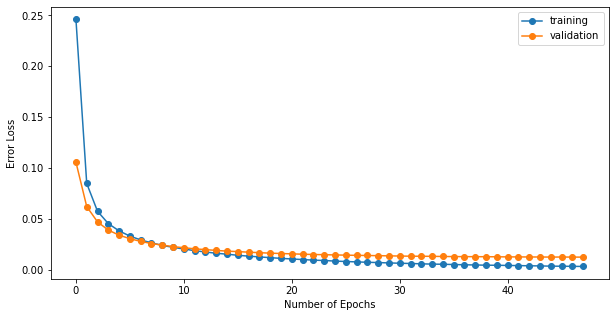

In [57]:
train_loss = net_train03.history[:, 'train_loss']
valid_loss = net_train03.history[:, 'valid_loss']
plt.figure(figsize=(10,5))
plt.plot(train_loss, 'o-', label='training')
plt.plot(valid_loss, 'o-', label='validation')
plt.xlabel('Number of Epochs', fontsize=10)
plt.ylabel('Error Loss', fontsize=10)
plt.legend()
plt.show() 

### 8A.2 Predict on X Val Seen Classes 03

In [58]:
y_pred03 = net_train03.predict(X_val_seen_classes3.astype(np.float32).values)

### 8A.3 print Classification Report

In [59]:
print(classification_report(y_val_seen_classes3.astype(np.float32).values, y_pred03, target_names=predicate_list))

              precision    recall  f1-score   support

       black       0.99      0.99      0.99      2149
       white       0.99      0.99      0.99      1612
        blue       1.00      0.99      0.99       134
       brown       0.99      0.99      0.99      2285
        gray       0.99      0.98      0.98      1208
      orange       1.00      0.99      0.99       269
         red       0.99      0.99      0.99       135
      yellow       1.00      1.00      1.00       269
     patches       0.98      0.98      0.98      1077
       spots       0.96      0.96      0.96       674
     stripes       1.00      1.00      1.00       402
       furry       1.00      1.00      1.00      3226
    hairless       0.99      0.98      0.99       672
   toughskin       0.99      0.99      0.99      1613
         big       1.00      1.00      1.00      2420
       small       0.99      0.99      0.99      1343
     bulbous       1.00      1.00      1.00      2148
        lean       0.99    

# 8B. Zero Shot Prediction on Unseen ValidationData 03

In [60]:
ValData03 = pd.read_csv("C:/Dissertation/Data/Processed Data/ValData03.csv")
ValData03.head()

Unnamed: 0            filenames         0         1         2         3  \
0           0  chihuahua_10001.jpg  0.457508  2.209699  0.249253  0.004099   
1           1  chihuahua_10002.jpg  0.000000  1.011257  0.096839  0.086607   
2           2  chihuahua_10003.jpg  0.015584  0.460842  0.250906  0.117762   
3           3  chihuahua_10004.jpg  0.069304  0.495944  0.039458  0.556074   
4           4  chihuahua_10005.jpg  0.124765  0.076797  0.622750  0.000000   

          4         5         6         7         8         9        10  \
0  2.162712  1.154035  1.164877  0.368082  1.631326  0.721534  3.851721   
1  0.033558  0.141780  0.020684  2.166317  0.309690  0.096642  0.948015   
2  0.611290  0.314423  0.595944  1.918241  0.428958  0.091063  2.223585   
3  0.047514  0.239595  0.775888  4.000928  0.106065  0.263034  1.499765   
4  0.179889  0.208473  0.480425  0.649823  1.449219  0.902047  0.528864   

         11        12        13        14        15        16        17  \
0  1.736946  3.665055  1.431712  1.483908  0.868416  5.413917  1.855609   
1  0.050076  0.070229  0.093283  1.556199  0.000000  0.348984  0.000000   
2  0.102836  0.252616  0.084373  0.655454  0.075881  0.442986  0.000000   
3  0.066923  0.738115  0.079341  0.586528  0.828172  0.301015  0.215291   
4  1.142781  0.078744  0.377913  1.162098  0.125477  0.198335  0.732469   

         18        19        20        21        22        23        24  \
0  0.204725  0.123023  0.044736  0.254974  0.178780  0.404450  0.144912   
1  0.141115  0.000000  0.552661  2.817987  0.017994  0.088957  2.982473   
2  0.485795  0.125846  0.459338  1.221763  0.309030  0.001782  1.997299   
3  0.615258  0.174449  0.566665  0.536643  0.061008  0.357964  1.099053   
4  1.208524  0.152690  0.042572  0.663383  0.000000  0.788352  0.588718   

         25        26        27        28        29        30        31  \
0  0.000000  0.423537  2.752962  0.478638  0.582246  0.230894  0.992789   
1  0.064470  0.393680  1.697956  0.224486  0.141661  0.218759  1.384128   
2  0.826116  0.549328  0.110106  0.649771  0.314448  0.146561  3.276641   
3  3.097401  1.442663  1.301539  0.395626  0.565543  0.176346  0.623585   
4  0.000000  0.003644  0.544592  0.124012  0.171954  0.425343  0.589628   

         32        33        34        35        36        37        38  \
0  0.202161  0.369982  0.781667  0.134562  0.118772  0.192834  3.075703   
1  0.051051  0.212771  0.000000  0.030503  1.703702  0.132290  1.891021   
2  0.602725  1.368491  2.413017  0.562183  1.799472  0.977779  1.050631   
3  0.833035  0.013394  0.751870  0.468464  0.639149  0.868233  0.763026   
4  0.512297  0.152514  1.407097  0.002298  1.209920  0.192096  0.037099   

         39        40        41        42        43        44        45  \
0  0.194162  1.964578  0.241059  0.757216  0.279980  1.213206  3.153355   
1  0.000000  0.609024  0.079550  0.218228  1.658400  0.345904  0.653128   
2  0.000000  0.103033  0.055906  0.254917  0.493878  0.417447  0.153916   
3  0.835863  0.121446  0.633346  0.615599  1.602141  0.316283  0.116455   
4  0.048317  0.246072  0.367197  0.065394  0.022991  0.368552  0.345630   

         46        47        48        49        50        51        52  \
0  4.133282  0.274526  0.000000  2.532129  1.824940  0.453030  1.040973   
1  0.807112  0.151019  0.290813  0.056571  0.002852  2.162946  0.405726   
2  0.814806  0.128530  0.042106  1.618994  0.139612  0.691916  0.055909   
3  0.121160  0.795799  0.055828  0.252144  0.137517  0.482616  0.264978   
4  1.456993  0.050857  0.000000  0.764232  0.057947  1.057106  0.444761   

         53        54        55        56        57        58        59  \
0  0.506836  0.752087  0.296920  0.101128  0.127505  0.987137  0.735025   
1  0.131672  0.464862  2.634573  0.294811  0.451341  2.768056  0.329459   
2  0.242147  0.280522  1.114523  0.771607  0.025618  7.194903  0.201044   
3  0.000000  0.764739  0.859535  0.105595  0.042627  2.527005  0.017378   
4 

### 8B.2 Predict labels for unseen ZSL classes Validation 02

In [61]:
y_pred_ZS03 = net_train03.predict(ValData03.iloc[:,2:2050].astype(np.float32).values)
predicatedf_ZSL03 = predicatedf[predicatedf['classes'].isin((val03_df.classes.unique()).tolist())]
predicates03 = np.array(predicatedf_ZSL03.iloc[:,1:86])

### 8B.3 Calculate pairwise Eucledian distance between predicted vectors and unseen class attribute vectors

In [98]:
euc_matrix03 = distance_matrix(y_pred_ZS03, predicates03, p=2)
print(euc_matrix03.shape)
euc_matrix03_df = pd.DataFrame(euc_matrix03, columns = np.array(predicatedf_ZSL03.classes).tolist())
#euc_matrix03_df = StandardScaler().fit_transform(euc_matrix03_df)
euc_matrix03_df = pd.DataFrame(euc_matrix03_df, columns = np.array(predicatedf_ZSL03.classes).tolist())

(9152, 13)


### 8B.4 Assign predicted label based on minimum Eucleadna distance

In [88]:
euc_matrix03_df['ZS_prediction'] = euc_matrix03_df.idxmin(axis=1)
euc_matrix03_df.head()

,siamese+cat,moose,humpback+whale,chimpanzee,squirrel,rhinoceros,rabbit,wolf,chihuahua,weasel,giant+panda,pig,raccoon,ZS_prediction
0,-1.847452,0.343193,0.094669,-0.104874,0.326754,-0.184521,0.135028,-1.245060,-1.486268,-1.169921,-0.432489,-0.905660,-0.622236,siamese+cat
1,-2.024663,0.459192,-0.018047,-0.529858,-0.301733,0.538455,0.242085,-1.414924,-2.064393,-1.003309,-0.217803,0.438596,-0.781415,chihuahua
2,-2.024663,0.459192,0.205873,-0.529858,-0.301733,0.339446,-0.434179,-0.760682,-2.064393,-1.003309,-0.217803,-0.129678,-0.781415,chihuahua
3,-2.606096,0.796388,0.315623,-0.385389,0.082992,0.439641,0.749855,-2.345773,-1.864395,-1.519563,0.404942,0.300270,-0.622236,siamese+cat
4,-1.676937,0.225245,0.423974,-0.529858,-0.301733,0.732155,0.242085,-1.079609,-1.306676,-1.003309,0.200737,0.708497,-0.163636,siamese+cat


In [89]:
ZS_matrix03 = pd.concat([euc_matrix03_df,ValData03['classes']], axis = 1)
ZS_matrix03.head()
#ZS_matrix03.to_csv("C:/Dissertation/Data/Processed Data/ZSL_Test03.csv")

,siamese+cat,moose,humpback+whale,chimpanzee,squirrel,rhinoceros,rabbit,wolf,chihuahua,weasel,giant+panda,pig,raccoon,ZS_prediction,classes
0,-1.847452,0.343193,0.094669,-0.104874,0.326754,-0.184521,0.135028,-1.245060,-1.486268,-1.169921,-0.432489,-0.905660,-0.622236,siamese+cat,chihuahua
1,-2.024663,0.459192,-0.018047,-0.529858,-0.301733,0.538455,0.242085,-1.414924,-2.064393,-1.003309,-0.217803,0.438596,-0.781415,chihuahua,chihuahua
2,-2.024663,0.459192,0.205873,-0.529858,-0.301733,0.339446,-0.434179,-0.760682,-2.064393,-1.003309,-0.217803,-0.129678,-0.781415,chihuahua,chihuahua
3,-2.606096,0.796388,0.315623,-0.385389,0.082992,0.439641,0.749855,-2.345773,-1.864395,-1.519563,0.404942,0.300270,-0.622236,siamese+cat,chihuahua
4,-1.676937,0.225245,0.423974,-0.529858,-0.301733,0.732155,0.242085,-1.079609,-1.306676,-1.003309,0.200737,0.708497,-0.163636,siamese+cat,chihuahua


### 8B.5 ZSL performance top-1 accuracy

In [90]:
print(classification_report(ZS_matrix03['classes'],ZS_matrix03['ZS_prediction']))

                precision    recall  f1-score   support

     chihuahua       0.61      0.52      0.56       567
    chimpanzee       0.78      0.90      0.84       728
   giant+panda       0.54      0.18      0.27       874
humpback+whale       0.73      0.99      0.84       709
         moose       0.62      0.62      0.62       704
           pig       0.56      0.44      0.49       713
        rabbit       0.47      0.81      0.60      1088
       raccoon       0.43      0.21      0.28       512
    rhinoceros       0.82      0.79      0.81       696
   siamese+cat       0.63      0.74      0.68       500
      squirrel       0.51      0.20      0.28      1200
        weasel       0.16      0.14      0.15       272
          wolf       0.42      0.87      0.56       589

      accuracy                           0.57      9152
     macro avg       0.56      0.57      0.54      9152
  weighted avg       0.57      0.57      0.54      9152



# 9A. Zero Shot Prediction on Unseen Test set

In [404]:
y_trainval_final

,black,white,blue,brown,gray,orange,red,yellow,patches,spots,stripes,furry,hairless,toughskin,big,small,bulbous,lean,flippers,hands,hooves,pads,paws,longleg,longneck,tail,chewteeth,meatteeth,buckteeth,strainteeth,horns,claws,tusks,smelly,flys,hops,swims,tunnels,walks,fast,slow,strong,weak,muscle,bipedal,quadrapedal,active,inactive,nocturnal,hibernate,agility,fish,meat,plankton,vegetation,insects,forager,grazer,hunter,scavenger,skimmer,stalker,newworld,oldworld,arctic,coastal,desert,bush,plains,forest,fields,jungle,mountains,ocean,ground,water,tree,cave,fierce,timid,smart,group,solitary,nestspot,domestic
0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,1,0,0,1,0,0,1,0,0,1,0,1,1,0,0,0,1,0,0,0,0,0,0,0,1,1,0,1,0,1,0,1,1,0,0,0,1,0,0,0,1,0,1,1,0,0,0,0,1,1,0,0,0,0,1,0,1,0,1,0,1,0,0,0,0,1,0,1,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,1,0,1,1,0,0,1,0,0,1,0,0,1,0,1,1,0,0,0,1,0,0,0,0,0,0,0,1,1,0,1,0,1,0,1,1,0,0,0,1,0,0,0,1,0,1,1,0,0,0,0,1,1,0,0,0,0,1,0,1,0,1,0,1,0,0,0,0,1,0,1,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,1,0,1,1,0,0,1,0,0,1,0,0,1,0,1,1,0,0,0,1,0,0,0,0,0,0,0,1,1,0,1,0,1,0,1,1,0,0,0,1,0,0,0,1,0,1,1,0,0,0,0,1,1,0,0,0,0,1,0,1,0,1,0,1,0,0,0,0,1,0,1,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,1,0,1,1,0,0,1,0,0,1,0,0,1,0,1,1,0,0,0,1,0,0,0,0,0,0,0,1,1,0,1,0,1,0,1,1,0,0,0,1,0,0,0,1,0,1,1,0,0,0,0,1,1,0,0,0,0,1,0,1,0,1,0,1,0,0,0,0,1,0,1,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,1,0,1,1,0,0,1,0,0,1,0,0,1,0,1,1,0,0,0,1,0,0,0,0,0,0,0,1,1,0,1,0,1,0,1,1,0,0,0,1,0,0,0,1,0,1,1,0,0,0,0,1,1,0,0,0,0,1,0,1,0,1,0,1,0,0,0,0,1,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36121,1,1,0,0,0,0,0,0,0,0,1,1,0,1,1,0,0,1,0,0,1,0,0,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,1,1,0,1,0,1,0,1,1,0,0,0,1,0,0,0,1,0,1,1,0,0,0,0,0,1,0,0,0,1,1,0,1,0,0,0,1,0,0,0,0,1,1,1,0,0,0
36122,1,1,0,0,0,0,0,0,0,0,1,1,0,1,1,0,0,1,0,0,1,0,0,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,1,1,0,1,0,1,0,1,1,0,0,0,1,0,0,0,1,0,1,1,0,0,0,0,0,1,0,0,0,1,1,0,1,0,0,0,1,0,0,0,0,1,1,1,0,0,0
36123,1,1,0,0,0,0,0,0,0,0,1,1,0,1,1,0,0,1,0,0,1,0,0,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,1,1,0,1,0,1,0,1,1,0,0,0,1,0,0,0,1,0,1,1,0,0,0,0,0,1,0,0,0,1,1,0,1,0,0,0,1,0,0,0,0,1,1,1,0,0,0
36124,1,1,0,0,0,0,0,0,0,0,1,1,0,1,1,0,0,1,0,0,1,0,0,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,1,1,0,1,0,1,0,1,1,0,0,0,1,0,0,0,1,0,1,1,0,0,0,0,0,1,0,0,0,1,1,0,1,0,0,0,1,0,0,0,0,1,1,1,0,0,0


In [433]:
y = y_train_final;
pos_weight = (y==0).sum()/(y==1).sum()
pos_weight = torch.Tensor(pos_weight)

In [153]:
torch.manual_seed(10)

net_train_final = NeuralNetClassifier(
ProjectionNetwork,
#iterator_train__shuffle=True, 
#iterator_valid__shuffle=True, 
batch_size=512,
module__num_units = 5096, #5096
module__non_linear = nn.ReLU(),
module__dropout = 0.2,
max_epochs=100,
lr=0.1,
criterion = torch.nn.modules.loss.BCEWithLogitsLoss, # to use with Sigmoid 
optimizer=torch.optim.SGD,
#optimizer__momentum = 0.95,
#optimizer__weight_decay = 0.001,
train_split = ValidSplit(5),
callbacks=[train_macro_F1_score,valid_macro_F1_score, CP_final],
callbacks__valid_acc=None,
device='cuda'
)

In [154]:
TrainValData_Smote = pd.read_csv("C:/Dissertation/Data/Processed Data/TrainData_Final.csv")

In [155]:
X_trainval_final = TrainValData_Smote.iloc[:,2:2050]
y_trainval_final = TrainValData_Smote.iloc[:,2052:2137]

In [156]:
X_train_final,X_val_seen_final,y_train_final,y_val_seen_final = train_test_split(X_trainval_final,y_trainval_final,stratify=y_trainval_final,test_size=0.1,random_state = 0)

In [157]:
X_final = X_train_final.astype(np.float32).values
y_final = y_train_final.astype(np.float32).values
net_train_final.fit(X_final,y_final) #to use with sigmoid and BCELOSS 

  epoch    train_f1_macro    train_loss    valid_acc    valid_f1_macro    valid_loss    cp     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ----  ------
      1            0.2723        0.5015       0.0000            0.2420        0.4867     +  1.4276
      2            0.2556        0.4898       0.0000            0.2420        0.4862     +  1.2420
      3            0.2560        0.4893       0.0000            0.2420        0.4858     +  1.2604
      4            0.2564        0.4890       0.0000            0.2420        0.4855     +  1.2374
      5            0.2564        0.4887       0.0000            0.2420        0.4851     +  1.2623
      6            0.2567        0.4883       0.0000            0.2420        0.4848     +  1.2458
      7            0.2572        0.4879       0.0000            0.2420        0.4844     +  1.2680
      8            0.2573        0.4876       0.0000            0.2420        0.4840     +  1.3529
      9   

     63            0.4329        0.3924       0.0000            0.4376        0.3869     +  1.2785
     64            0.4360        0.3902       0.0000            0.4417        0.3846     +  1.2868
     65            0.4398        0.3879       0.0000            0.4449        0.3822     +  1.2571
     66            0.4432        0.3853       0.0000            0.4484        0.3798     +  1.2357
     67            0.4466        0.3830       0.0000            0.4523        0.3773     +  1.2458
     68            0.4499        0.3806       0.0000            0.4555        0.3748     +  1.3136
     69            0.4530        0.3781       0.0000            0.4595        0.3723     +  1.3609
     70            0.4568        0.3756       0.0000            0.4629        0.3697     +  1.2483
     71            0.4604        0.3729       0.0000            0.4660        0.3671     +  1.2132
     72            0.4634        0.3702       0.0000            0.4691        0.3644     +  1.2293
     73   

<class 'skorch.classifier.NeuralNetClassifier'>[initialized](
  module_=ProjectionNetwork(
    (fc1): Linear(in_features=2048, out_features=5096, bias=True)
    (fc2): Linear(in_features=5096, out_features=5096, bias=True)
    (fc3): Linear(in_features=5096, out_features=85, bias=True)
    (nonlinear): Sigmoid()
    (dropout): Dropout(p=0.2, inplace=False)
  ),
)

In [158]:
net_train_final.load_params(checkpoint=CP_final)

### 9A.1 Plot Training and Validation Error

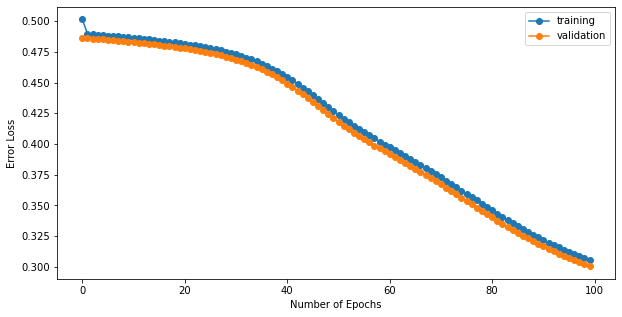

In [159]:
train_loss = net_train_final.history[:, 'train_loss']
valid_loss = net_train_final.history[:, 'valid_loss']
plt.figure(figsize=(10,5))
plt.plot(train_loss, 'o-', label='training')
plt.plot(valid_loss, 'o-', label='validation')
plt.xlabel('Number of Epochs', fontsize=10)
plt.ylabel('Error Loss', fontsize=10)
plt.legend()
plt.show() 

### 9A.2 Predict on X Val Seen Classes Final

In [160]:
y_pred_final = net_train_final.predict(X_val_seen_final.astype(np.float32).values)

### 9A.3 print Classification Report

In [161]:
print(classification_report(y_val_seen_final.astype(np.float32).values, y_pred_final, target_names=predicate_list))

              precision    recall  f1-score   support

       black       0.66      0.99      0.79      1800
       white       0.70      0.54      0.61      1303
        blue       0.00      0.00      0.00       146
       brown       0.74      0.98      0.84      1915
        gray       0.75      0.64      0.69      1243
      orange       0.00      0.00      0.00       154
         red       0.00      0.00      0.00        66
      yellow       0.00      0.00      0.00       174
     patches       0.63      0.41      0.49      1076
       spots       0.00      0.00      0.00       633
     stripes       0.00      0.00      0.00       275
       furry       0.94      0.99      0.97      2528
    hairless       0.81      0.70      0.75       541
   toughskin       0.90      0.88      0.89      1353
         big       0.95      0.96      0.96      2137
       small       0.89      0.83      0.86       980
     bulbous       0.86      0.84      0.85      1614
        lean       0.82    

# 9B. Zero Shot Prediction on Unseen Test Data

In [162]:
TestData_final = pd.read_csv("C:/Dissertation/Data/Processed Data/TestData_Final.csv")
TestData_final.head()

Unnamed: 0      filenames         0         1         2         3  \
0           0  bat_10001.jpg  0.538586  1.180697  0.107359  1.281290   
1           1  bat_10002.jpg  0.115222  2.614796  0.187046  1.045649   
2           2  bat_10003.jpg  0.047812  0.000000  0.684833  0.670863   
3           3  bat_10004.jpg  0.160263  0.371737  0.673789  1.048876   
4           4  bat_10005.jpg  0.077933  0.147916  0.340398  1.077395   

          4         5         6         7         8         9        10  \
0  0.717876  0.056772  0.094561  0.061106  0.242003  1.251059  0.678831   
1  0.195824  0.005454  0.000000  0.000000  3.530893  0.384756  0.006119   
2  0.000000  2.047367  0.386138  0.155478  0.000000  1.436935  0.360700   
3  0.000000  0.000000  0.330649  0.503631  1.351576  2.549043  1.177580   
4  0.105623  0.710672  0.093208  0.049504  0.167506  0.005357  0.685458   

         11        12        13        14        15        16        17  \
0  0.055451  0.033369  0.398013  1.074002  0.934236  0.000000  0.550287   
1  5.167186  0.000000  0.010197  0.581606  0.938897  0.172252  0.757495   
2  0.152219  0.444474  0.040298  0.547725  0.124256  1.818815  0.272204   
3  1.048437  0.000000  0.252591  0.573532  0.494580  0.237027  0.682669   
4  0.308390  0.107323  0.000000  0.048113  0.069770  3.561314  0.000000   

         18        19        20        21        22        23        24  \
0  0.025533  1.657240  0.405544  0.065878  0.222624  2.055550  0.000000   
1  0.121764  0.024506  0.236460  0.215925  0.000000  2.151342  0.012164   
2  0.155898  0.769462  0.364229  0.000000  0.179798  0.027858  0.314003   
3  0.170089  1.235237  0.047058  0.062543  0.233716  2.944882  0.112473   
4  1.824932  0.056521  0.058412  2.126566  0.022979  0.262033  0.066164   

         25        26        27        28        29        30        31  \
0  0.000000  0.015525  0.006650  0.108544  1.464134  0.035806  0.036707   
1  0.055999  0.758323  0.095614  0.000000  0.000000  0.152538  0.001502   
2  0.730725  0.000000  0.023522  0.015412  0.000000  2.437346  0.062121   
3  0.020247  1.778959  0.031025  0.558402  0.033195  0.286793  0.000000   
4  0.138871  0.229375  0.076778  0.395283  0.018152  0.029847  0.000000   

         32        33        34        35        36        37        38  \
0  0.483072  0.963912  0.635038  1.656688  0.499141  0.085987  0.916616   
1  0.006817  0.084971  0.125999  0.634439  0.354882  0.008813  0.085260   
2  0.002974  1.906236  1.084533  0.119916  2.060274  1.537994  0.343323   
3  0.141539  0.227862  0.978633  0.518358  2.009592  0.113970  0.000000   
4  0.000000  2.219054  1.607813  1.744721  0.235373  0.046693  0.013844   

         39        40        41        42        43        44        45  \
0  0.239686  0.039912  0.408856  0.217714  0.204090  1.123250  0.000000   
1  0.000000  0.800311  0.022884  0.008188  0.000000  0.011412  0.101471   
2  0.221933  0.085682  1.040102  2.055221  0.087727  0.606482  0.276811   
3  0.011751  0.092659  1.985292  0.009295  0.346239  0.978080  0.290803   
4  0.000000  0.396335  0.000000  1.179632  0.051630  0.206446  0.366064   

         46        47        48        49        50        51        52  \
0  0.616969  1.709176  0.513323  1.424003  0.000000  0.114103  1.513335   
1  0.083022  1.585219  0.000000  3.592371  0.182353  0.082425  0.818891   
2  1.093935  0.000000  0.707319  1.653867  0.027731  0.000000  4.063280   
3  0.940004  0.054582  0.035574  0.597407  0.934195  0.507786  0.075546   
4  2.196269  0.179728  0.182030  0.429128  0.000000  1.433681  2.552275   

         53        54        55        56        57        58        59  \
0  0.000000  2.047963  0.858357  0.748378  0.061547  0.000000  0.095115   
1  0.369466  0.064095  0.916034  0.000000  0.002931  0.028475  0.280052   
2  0.000000  0.169837  0.000000  0.054210  0.000000  0.152576  0.814497   
3  0.136609  0.059492  1.354013  0.056161  0.025416  0.306081  0.161211   
4  0.000000  0.274726  0.249392  0.188

### 9B.2 Predict labels for unseen ZSL classes Test classes

In [163]:
y_pred_ZS_final = net_train_final.predict(TestData_final.iloc[:,2:2050].astype(np.float32).values)
predicatedf_ZSL_final = predicatedf[predicatedf['classes'].isin((test_df.classes.unique()).tolist())]
predicates_final = np.array(predicatedf_ZSL_final.iloc[:,1:86])

### 9B.3 Calculate pairwise Eucledian distance between predicted vectors and unseen class attribute vectors

In [164]:
euc_matrix_final = distance_matrix(y_pred_ZS_final, predicates_final, p=2)
print(euc_matrix_final.shape)
euc_matrix_final_df = pd.DataFrame(euc_matrix_final, columns = np.array(predicatedf_ZSL_final.classes).tolist())
#euc_matrix_final_df = StandardScaler().fit_transform(euc_matrix_final_df)
euc_matrix_final_df = pd.DataFrame(euc_matrix_final_df, columns = np.array(predicatedf_ZSL_final.classes).tolist())

(7913, 10)


### 9B.4 Assign predicted label based on minimum Eucleadna distance

In [165]:
euc_matrix_final_df['ZS_prediction'] = euc_matrix_final_df.idxmin(axis=1)
euc_matrix_final_df.head()

,horse,blue+whale,sheep,seal,bat,giraffe,rat,bobcat,walrus,dolphin,ZS_prediction
0,4.472136,6.164414,5.000000,5.291503,5.744563,5.744563,4.582576,5.196152,6.164414,5.291503,horse
1,4.358899,5.196152,4.690416,5.196152,5.830952,4.898979,5.291503,5.099020,5.567764,5.000000,horse
2,4.000000,5.477226,4.795832,5.291503,5.744563,4.795832,5.196152,5.000000,5.656854,4.690416,horse
3,4.123106,4.795832,4.242641,4.795832,5.830952,4.690416,5.477226,5.830952,4.795832,5.000000,horse
4,3.316625,5.916080,4.690416,5.567764,5.830952,4.242641,5.291503,5.099020,6.082763,5.000000,horse


In [166]:
ZS_matrix_final = pd.concat([euc_matrix_final_df,TestData_final['classes']], axis = 1)
ZS_matrix_final.head()
ZS_matrix_final.to_csv("C:/Dissertation/Data/Processed Data/ZSL_Test_final.csv")

### 9B.5 ZSL performance top-1 accuracy

In [167]:
print(classification_report(ZS_matrix_final['classes'],ZS_matrix_final['ZS_prediction']))

              precision    recall  f1-score   support

         bat       0.00      0.00      0.00       383
  blue+whale       0.10      0.60      0.17       174
      bobcat       0.83      0.87      0.85       630
     dolphin       0.00      0.00      0.00       946
     giraffe       0.00      0.00      0.00      1202
       horse       0.28      0.49      0.35      1645
         rat       0.34      0.50      0.40       310
        seal       0.80      0.08      0.15       988
       sheep       0.36      0.54      0.43      1420
      walrus       0.11      0.23      0.15       215

    accuracy                           0.32      7913
   macro avg       0.28      0.33      0.25      7913
weighted avg       0.31      0.32      0.26      7913

